#**Multivariate Time Series Forecasting for Insurance Stock Using Macroeconomic Indicators**

**Problem Statement**
The objective of this project is to forecast the quarterly closing price of an insurance stock (AIG) using a multivariate time series model that incorporates macroeconomic indicators. This has applications in financial planning, risk management, and investment strategy.

**Step 1**

**Data Acquisition**
**AIG stock data** is fetched monthly from yfinance and then resampled to quarter‑end values, giving us our primary series, AIG.

**Macroeconomic data (Real GDP, CPI, Unemployment Rate**) come from FRED and are aligned to the same quarter‑end dates.

These 2 (AIG stock data and Macroeconomic data) are merged into one DataFrame, ensuring there are no missing entries.

 **Step 2: Exploratory Data Analysis (EDA)**
Summary stats and missing values were checked.

Line plots visualized seasonal and trend components.

Seasonal Decomposition of the target (AIG).

Correlation matrix revealed relationships between variables.

**Step 3: Feature Engineering**
Created lagged and rolling average features for each time series.

Added lag1 and rolling mean (window=2) columns for both stock and macro features.

**Step 4: Stationarity & Differencing**
Used the ADF test to check stationarity.

Differenced non-stationary series using percentage change.

Final set of features included both raw and differenced values.

**Step 5: Scaling**
StandardScaler was applied to the entire DataFrame to prepare for modeling.

**Step 6: Granger Causality Tests**

Granger Causality Tests to identify macroeconomic variables that statistically cause changes in AIG.

Correlation with Target measured feature relevance before modeling.

**Step 7: Train-Test Split**

Split done chronologically (time-aware), not randomly.

**Step 8: Model Training, forecasting and evaluation**

Trained the data on VAR and XG-Boost

**Summary**

Built an end-to-end multivariate forecasting system.

Combined statistical models (VAR) and machine learning models (XGBoost).

Incorporated real-world macroeconomic context to improve prediction.

#Importing Libraries

In [ ]:
import pandas as pd , numpy as np , matplotlib.pyplot as plt , seaborn as sns, yfinance as yf
from pandas_datareader import data as pdr

#Data Acquisition

In [ ]:
#Download insurance stock (AIG) monthly prices and resample quarterly
stock = yf.download('AIG', start='2015-01-01', end='2025-01-01', interval='1mo')

# Extract closing price series and resample to quarter-end ('QE'), then rename
close_df = stock['Close']

# Resample at quarter end ('QE') and take last observation
target_q = close_df.resample('QE').last()

# Rename column to 'target'
target_q.rename(columns={'Close': 'target'}, inplace=True)
claims_df = target_q


/tmp/ipython-input-2-2877806668.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download('AIG', start='2015-01-01', end='2025-01-01', interval='1mo')
[*********************100%***********************]  1 of 1 completed


In [ ]:
claims_df.head()

Ticker,AIG
Date,
2015-03-31,42.543678
2015-06-30,48.109562
2015-09-30,44.311291
2015-12-31,48.559849
2016-03-31,42.541306


In [ ]:
#Download macroeconomic indicators from FRED indicators

macro_symbols = ['GDP', 'CPILFESL', 'UNRATE']  # Real GDP, CPI, Unemployment Rate
macro_df = pdr.DataReader(macro_symbols, 'fred',
                          start=claims_df.index.min(),
                          end=claims_df.index.max())
macro_df = macro_df.resample('QE').last()

In [ ]:
macro_df.head()

,GDP,CPILFESL,UNRATE
DATE,,,
2015-06-30,18279.784,242.064,5.3
2015-09-30,18401.626,243.316,5.0
2015-12-31,18435.137,244.547,5.0
2016-03-31,18525.933,245.913,5.0
2016-06-30,18711.702,247.540,4.9


In [ ]:
# 2.3 Merge datasets on quarterly index

df = pd.concat([claims_df, macro_df], axis=1).dropna()

In [ ]:
df.head()

,AIG,GDP,CPILFESL,UNRATE
2015-06-30,48.109562,18279.784,242.064,5.3
2015-09-30,44.311291,18401.626,243.316,5.0
2015-12-31,48.559849,18435.137,244.547,5.0
2016-03-31,42.541306,18525.933,245.913,5.0
2016-06-30,41.888119,18711.702,247.540,4.9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2015-06-30 to 2024-12-31
Freq: QE-DEC
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AIG       39 non-null     float64
 1   GDP       39 non-null     float64
 2   CPILFESL  39 non-null     float64
 3   UNRATE    39 non-null     float64
dtypes: float64(4)
memory usage: 1.5 KB


In [ ]:
df.describe()

,AIG,GDP,CPILFESL,UNRATE
count,39.000000,39.000000,39.000000,39.000000
mean,48.310683,22804.145359,274.468000,4.558974
std,12.267140,3661.890579,25.440197,1.419362
min,20.979597,18279.784000,242.064000,3.500000
25%,43.522387,19814.019500,253.578000,3.750000
50%,47.618820,21717.171000,266.020000,4.100000
75%,52.283562,26038.901000,296.145000,4.950000
max,75.765762,29723.864000,323.296000,11.000000


#EDA

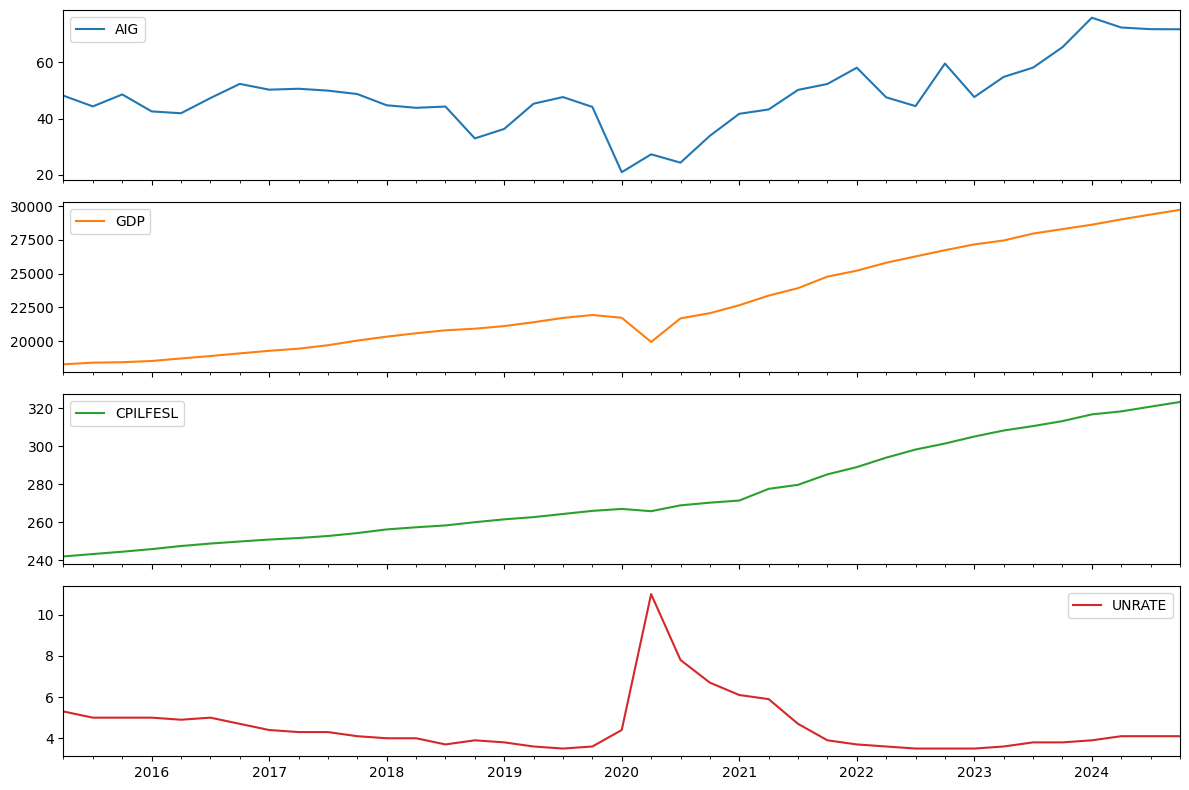

In [ ]:
# Plot series
df.plot(subplots=True, figsize=(12, 8))
plt.tight_layout()
plt.show()

**Explanation**

AIG (Stock Price) fluctuated between 30 - 70 dollars, saw a sharp dip in 2020 due to COVID-19, followed by a steady post-pandemic recovery

US real GDP shows a long-term upward trend, with a sharp dip in Q2 2020 from COVID-19, followed by a swift recovery and continued growth.

Core CPI (CPILFESL) shows a smooth, steady rise, with a sharper post-2020 uptick reflecting underlying inflation pressures after the pandemic

The unemployment rate showed a steady decline until a sharp spike in Q2 2020 due to the pandemic, followed by a rapid recovery to pre-pandemic levels by 2022.

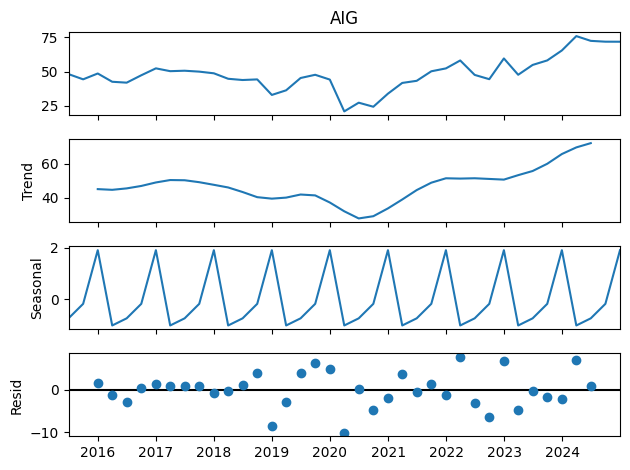

In [ ]:
# Decompose target series (period=4 for quarterly)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['AIG'], model='additive', period=4)
result.plot()
plt.show()

**Explanation**

**Trend** : The stock's long-term trend was flat until 2019, dipped during the 2020 pandemic, then surged upward, signaling strong post-shock growth.

**Seasonality**: The stock exhibits consistent seasonal patterns with small, periodic peaks every 4 quarters, likely driven by investor behavior, earnings cycles, or insurance seasonality

**Residual**: The residuals fluctuate randomly around zero with some outliers in 2020, indicating minimal remaining structure after removing trend and seasonality.

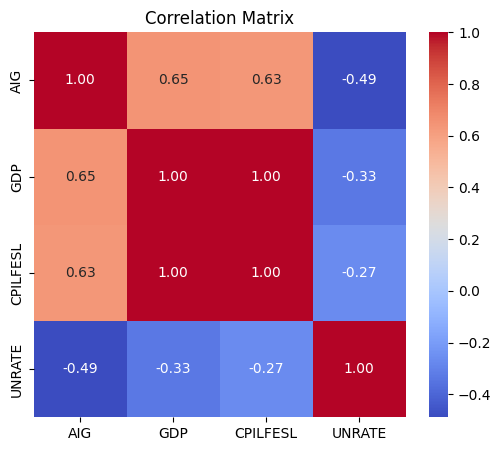

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


**Explanation**

AIG - GDP shows strong positive relationship. As GDP grows, AIG stock tends to increase.

AIG–CPILFESL also strongly positively correlated. Rising core inflation may reflect economic growth, benefitting insurers.

AIG–UNRATE shows moderate negative correlation. As unemployment rises, AIG stock tends to fall—likely due to lower economic activity.

**Summary**

AIG stock is highly sensitive to macroeconomic trends—particularly economic growth (GDP), inflation (CPI), and employment.

These variables are appropriate predictors for a multivariate time series model like VAR or XGBoost

In [ ]:
#Preprocessing
# Feature engineering: lags and rolling means

for col in df.columns:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_roll2'] = df[col].rolling(window=2).mean()
df.dropna(inplace=True)

#Checking Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    stat, p, *_ = adfuller(series)
    print(f'{name}: ADF stat={stat:.3f}, p={p:.3f}')
    return p

# Identify which base series need differencing
base_cols = ['AIG', 'GDP', 'CPILFESL', 'UNRATE']
pvals = {col: adf_test(df[col], col) for col in base_cols}

# Decide differencing: p-value >= 0.05 indicates non-stationarity
diff_needed = [col for col, p in pvals.items() if p >= 0.05]
print('Differencing needed for:', diff_needed)

AIG: ADF stat=-1.311, p=0.624
GDP: ADF stat=0.950, p=0.994
CPILFESL: ADF stat=2.086, p=0.999
UNRATE: ADF stat=-2.901, p=0.045
Differencing needed for: ['AIG', 'GDP', 'CPILFESL']


#Applying differencing

In [ ]:
# Apply first-order differencing only to non-stationary series
diff_cols = []
for col in base_cols:
    if col in diff_needed:
        df[f'{col}_diff'] = df[col] - df[col].shift(1)
        diff_cols.append(f'{col}_diff')
    else:
        # Keep stationary series as-is (use original)
        diff_cols.append(col)

df.dropna(inplace=True)

#Scalling Using Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

#Checking Casuality

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

print("""
--- Granger Causality Test Results ---""")
for col in diff_cols:
    if col != f'{"AIG"}_diff':
        # print(f"Does {col} Granger-cause {"AIG"}_diff?")
        grangercausalitytests(df[[f'{"AIG"}_diff', col]], maxlag=4, verbose=True)


--- Granger Causality Test Results ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7627  , p=0.1934  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=1.9230  , p=0.1655  , df=1
likelihood ratio test: chi2=1.8734  , p=0.1711  , df=1
parameter F test:         F=1.7627  , p=0.1934  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7263  , p=0.1952  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=4.0280  , p=0.1335  , df=2
likelihood ratio test: chi2=3.8126  , p=0.1486  , df=2
parameter F test:         F=1.7263  , p=0.1952  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2195  , p=0.3217  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=4.6069  , p=0.2030  , df=3
likelihood ratio test: chi2=4.3204  , p=0.2289  , df=3
parameter F test:         F=1.2195  , p=0.3217  , df_denom=27, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


**Explanation**

Granger Causality doesn’t imply true causality, but rather tells us whether past values of one time series help predict another

None of the tested macro indicators (GDP, CPI, UNRATE) Granger-cause AIG’s stock price at a statistically significant level (p < 0.05)

#Train test split

In [ ]:
# Step 7: Train-Test Split & Cross-Validation
# ================================
from sklearn.model_selection import TimeSeriesSplit
ticker = "AIG"
# Step 7: Train-Test Split for VAR
train = df_scaled.loc[:'2022-12-31']
test = df_scaled.loc['2023-01-01':]

# Use only the differenced (stationary) columns
train_diff = train[diff_cols]
test_diff = test[diff_cols]



#Model Training [VAR]

In [ ]:
from statsmodels.tsa.api import VAR
# Fit VAR model
model = VAR(endog=train_diff)

# Select optimal lag order
lag_order_results = model.select_order(maxlags=4)
print(lag_order_results.summary())
opt_lag = lag_order_results.aic
print("Selected lag based on AIC:", opt_lag)


# Fit the model with optimal lag
results = model.fit(opt_lag)

# Forecast
forecast = results.forecast(train_diff.values[-opt_lag:], steps=len(test_diff))
forecast_df = pd.DataFrame(forecast, index=test_diff.index, columns=diff_cols)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.7005      0.8955       2.015      0.7545
1      -3.614      -2.638     0.02755      -3.343
2      -4.527      -2.772     0.01237      -4.041
3      -5.602     -3.067*   0.005792*      -4.899
4     -5.890*      -2.575    0.009117     -4.971*
-------------------------------------------------
Selected lag based on AIC: 4


In [ ]:
# lag = results.k_ar
# forecast = results.forecast(train[diff_cols].values[-lag:], steps=len(test))
# forecast_df = pd.DataFrame(forecast, index=test.index, columns=diff_cols)

In [ ]:
forecast_df

,AIG_diff,GDP_diff,CPILFESL_diff,UNRATE
2023-03-31,-1.944537,1.835633,2.285828,-2.073042
2023-06-30,0.105112,-1.030189,0.552985,-1.183762
2023-09-30,-0.685905,0.873217,1.090670,-1.598088
2023-12-31,-1.214340,-0.504888,1.211717,-0.952064
2024-03-31,0.547228,0.034643,-0.280343,-0.943777
2024-06-30,-1.213736,1.014186,1.443448,-1.655000
2024-09-30,-0.506274,-1.092932,-0.505760,-0.874059
2024-12-31,-0.330800,0.231920,0.482767,-0.763152


In [ ]:
actual_df = df_scaled[["AIG_diff", "GDP_diff","CPILFESL_diff", "UNRATE"]]

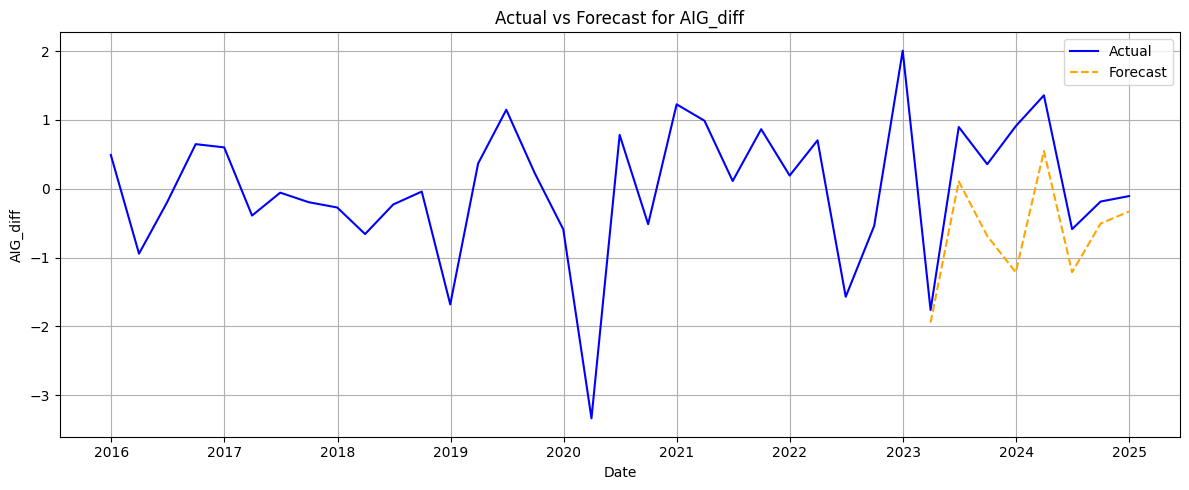

In [ ]:
import matplotlib.pyplot as plt

# Plot each column

plt.figure(figsize=(12, 5))
plt.plot(actual_df.index, actual_df["AIG_diff"], label='Actual', color='blue')
plt.plot(forecast_df.index, forecast_df["AIG_diff"], label='Forecast', color='orange', linestyle='--')
plt.title(f'Actual vs Forecast for AIG_diff')
plt.xlabel('Date')
plt.ylabel("AIG_diff")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# print('MAE:', mean_absolute_error(actual_df["AIG_diff"].iloc[-8:], forecast_df["AIG_diff"]))
aligned_actual = actual_df["AIG_diff"].loc[forecast_df.index]
print('MAE:', mean_absolute_error(aligned_actual, forecast_df["AIG_diff"]))


MAE: 0.7644475236904735


#Using XG-Boost

In [ ]:
#Benchmarking with XGBoost

ticker = "AIG"
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit

# Use lag/rolling features as predictors
X_cols = [col for col in df.columns if '_lag' in col or '_roll' in col]
y_col = f'{ticker}_diff'

X_train = train[X_cols]
y_train = train[y_col]
X_test = test[X_cols]
y_test = test[y_col]




In [ ]:
# Evaluating Metrics


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)
model = XGBRegressor()

fold_rmse = []
y_true_all = []
y_pred_all = []

for train_idx, val_idx in tscv.split(X_train):
    X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_t, y_t)
    preds = model.predict(X_v)

    fold_rmse.append(np.sqrt(mean_squared_error(y_v, preds)))
    y_true_all.extend(y_v)
    y_pred_all.extend(preds)

print('--- XGBoost (Raw % Change) ---')
print('Average Fold RMSE:', np.mean(fold_rmse))
print('Overall MAE:', mean_absolute_error(y_true_all, y_pred_all))
print('Overall RMSE:', np.sqrt(mean_squared_error(y_true_all, y_pred_all)))


--- XGBoost (Raw % Change) ---
Average Fold RMSE: 0.9045371164614275
Overall MAE: 0.6345718363868207
Overall RMSE: 0.922077769815283


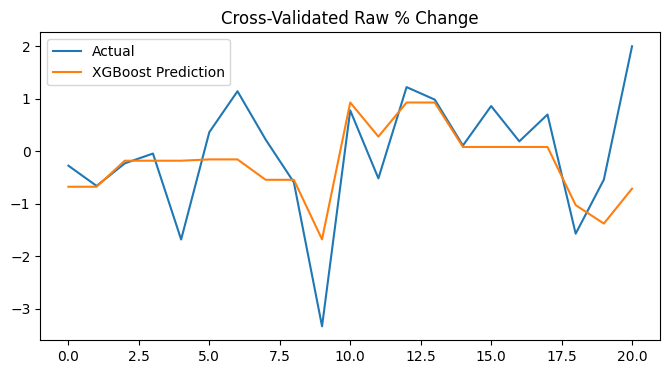

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_true_all, label='Actual')
plt.plot(y_pred_all, label='XGBoost Prediction')
plt.legend(); plt.title('Cross-Validated Raw % Change'); plt.show()


#Hyper Parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
import numpy as np

#  model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

#parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

#Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

# Parameters
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

#Evaluate on test set
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Test MAE:", mean_absolute_error(y_test, y_pred_best))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE: 0.8194041605855737
Test MAE: 0.8803066680851019
Test RMSE: 0.9659637757684871


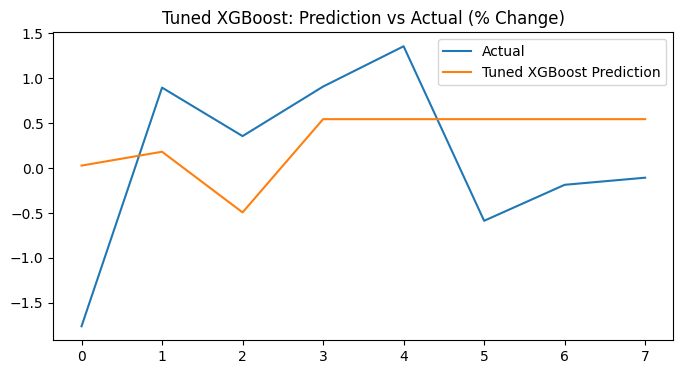

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_best, label='Tuned XGBoost Prediction')
plt.title('Tuned XGBoost: Prediction vs Actual (% Change)')
plt.legend(); plt.show()


**Metric Evaluation**

Cross-validated RMSE improved after tuning, which indicates better generalization during training.

However, test MAE and RMSE increased slightly, which may suggest mild overfitting or underfitting in the final test fold.

Overall, the tuned model performs more consistently across folds, even if slightly less accurate on final unseen data.

#Checking Feature Importance

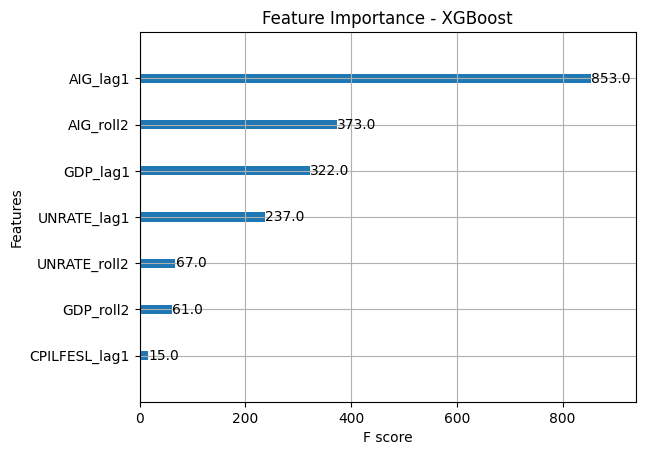

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


_ = plot_importance(best_model.best_estimator_ if hasattr(best_model, 'best_estimator_') else best_model)
plt.title("Feature Importance - XGBoost")
plt.show()

**Explanation**

Lag features dominate the model is learning from recent historical values more than smoothed ones.

Macroeconomic indicators (GDP, Unemployment) provide contextual strength, but stock-specific lags matter more.

CPI seems least important in the current window, possibly due to its indirect link to short-term stock movements.